# Wikipedia recommender system

* Oskar Szudzik 148245
* Krystian Moras 148243

First we need to scrape and preprocess articles from wikipedia.

In [274]:
import wikipedia

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize

porter = PorterStemmer()
wordnet = WordNetLemmatizer()
COLUMNS = ["title","summary","links","categories","references"]

def download_article():
    try:
        return wikipedia.page(title=wikipedia.random(1))
    except: # sometimes the package can't find the article but the title is a random title from the list of articles
        return download_article()


def preprocess_article(article):

    title = article.title
    summary = wordnet.lemmatize(porter.stem(article.summary))
    content =wordnet.lemmatize(porter.stem(article.content))
    content = " ".join([word for word in content.split() if word not in set(stopwords.words('english'))])

    categories = "|".join(article.categories)
    links = "|".join(article.links)
    try:
        references = "|".join(article.references)
    except KeyError:
        references = ""
    return title,summary,content,links,categories,references
def save_article(title,summary,content,links,categories,references):
    try:
        df = pd.read_csv(open("wikipedia2.csv",encoding="utf-8"),encoding_errors='ignore').set_index("title")
        df.loc[title] = (summary,content,links,categories,references)
    except pd.errors.EmptyDataError as e:
        preprocessed_dict = {"title":title,"summary":summary,"content":content,"links":links,"categories":categories,"references":references}
        df = pd.DataFrame.from_records([preprocessed_dict],index="title")
    # We append the articles one by one in case there is an error, 
    df.to_csv(open("wikipedia2.csv",mode="w",encoding="utf-8"))

Download the articles and put them to wikipedia.csv file

In [221]:

for i in range(10):
    article = download_article()
    print(article.title)
    title,summary,content,links,categories,references = preprocess_article(article)
    save_article(title,summary,content,links,categories,references)

Slevin's mouse
Sam Kutesa
Jennifer Siebel Newsom
Photo response non-uniformity
Banksia dallanneyi var. dallanneyi
Tudor Vladimirescu National College
Jimmy Flint
The Remixes – Volume 2
Saheb Bahadur
DJ Mog


## Dataset statistics

Number of articles

In [257]:
data = pd.read_csv('wikipedia2.csv', header=0)
data.head()
len(data)

758

Most common words in the whole dataset

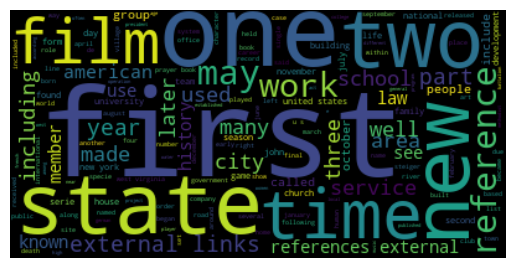

In [258]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
# Start with one review:
text = " ".join(data.content)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Categories and their counts

In [259]:
import numpy as np

categories = data['categories'].str.split('|')
categories = categories.explode()
val_counts = categories.value_counts()

val_counts = val_counts[:25]
print(val_counts.to_markdown())

|                                              |   categories |
|:---------------------------------------------|-------------:|
| Articles with short description              |          574 |
| Short description is different from Wikidata |          351 |
| All stub articles                            |          299 |
| Short description matches Wikidata           |          222 |
| Coordinates on Wikidata                      |          135 |
| Living people                                |          131 |
| Articles with VIAF identifiers               |          110 |
| Articles with WORLDCATID identifiers         |           96 |
| AC with 0 elements                           |           93 |
| Articles with LCCN identifiers               |           85 |
| All articles needing additional references   |           69 |
| Articles with hCards                         |           65 |
| Articles with ISNI identifiers               |           65 |
| Articles with GND identifiers         

We will perform TF-IDF for summary of articles. To later propose similar articles to ones liked by a client.

In [147]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from scipy.spatial.distance import cosine

In [260]:
article = data.iloc[0]
article.content

"slevin's mouse (peromyscus slevini), also known catalina deer mouse, species rodent family cricetidae. endemic isla santa catalina east coast baja california sur, island area 40 km2 (15 sq mi), native mammal island. named joseph slevin, curator california academy sciences.slevin's mouse large-bodied mouse, measuring 21 cm (8.3 in) total length, 10 centimetres (3.9 in) tail. pale cinnamon fur, mixed dusky hairs, body, head, flanks, near-white underparts. appear similar related california mouse, paler color slightly larger. however, may closely related north american deer mouse.the species threatened competition introduced northern baja deer mouse, probably introduced local fishermen. == references =="

In [261]:
articles = np.array(data.title)

summaries = np.array(data.content)
summaries[:2]

array(["slevin's mouse (peromyscus slevini), also known catalina deer mouse, species rodent family cricetidae. endemic isla santa catalina east coast baja california sur, island area 40 km2 (15 sq mi), native mammal island. named joseph slevin, curator california academy sciences.slevin's mouse large-bodied mouse, measuring 21 cm (8.3 in) total length, 10 centimetres (3.9 in) tail. pale cinnamon fur, mixed dusky hairs, body, head, flanks, near-white underparts. appear similar related california mouse, paler color slightly larger. however, may closely related north american deer mouse.the species threatened competition introduced northern baja deer mouse, probably introduced local fishermen. == references ==",
       "sam kahamba kutesa (born 1 february 1949) ugandan politician, businessman lawyer involved several corruption cases. marriage daughter charlotte kutesa muhoozi muhoozi part inner circle president museveni. kutesa minister foreign affairs cabinet uganda, position held 13 jan

In [262]:
tfidf=TfidfVectorizer(stop_words='english',use_idf=True, smooth_idf=False) 
 
dfTFIDF = pd.DataFrame(tfidf.fit_transform(summaries).toarray(), index=articles, columns=tfidf.get_feature_names_out())
dfTFIDF.head()

,00,000,0000000200,000th,001,002,003,00319,0036,005,...,裕行,见义勇为的英雄战士徐洪刚,警魂,通一兵,陆军第33师,非鉄連合,黄人黄土,齊哀公,김창봉,슈퍼주니어
Slevin's mouse,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sam Kutesa,0.0,0.057025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jennifer Siebel Newsom,0.0,0.011026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Photo response non-uniformity,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Banksia dallanneyi var. dallanneyi,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [272]:
query = "Sam Kutesa"
mask = data['title'] == query
pos = np.flatnonzero(mask)
print(pos)
query_summary = data.iloc[pos].content.item()
print(query_summary)
query = tfidf.transform([query_summary]).toarray()[0] 
results = 1-dfTFIDF.apply(lambda x: cosine(x, query), axis=1).sort_values()[:5]
results

[1]
sam kahamba kutesa (born 1 february 1949) ugandan politician, businessman lawyer involved several corruption cases. marriage daughter charlotte kutesa muhoozi muhoozi part inner circle president museveni. kutesa minister foreign affairs cabinet uganda, position held 13 january 2005 maintained three cabinet reshuffles may 2021. also elected member parliament (mp) mawogola county sembabule district. president united nations general assembly 69th session 2014–2015. == early life education == kutesa attended mbarara high school. bachelor laws degree makerere university, back institution part university east africa. also postgraduate diploma legal practice law development centre kampala. == career == kutesa private law practice 1973 2001. served member parliament (mp) mbarara north constituency 1980 1985 attorney general 1985 1986. 1994 1995, served delegate constituent assembly drafted 1995 ugandan constitution. elected mp mawogola county 2001 re-elected 2006. minister state investment

Sam Kutesa                                           1.000000
Rights of nature                                     0.085316
Central Financial and Economic Affairs Commission    0.078575
Constitutional law                                   0.073874
Oil record book                                      0.072072
dtype: float64

Okay, but we would like to apply it to a list of liked articles.

First download the articles if they are not already in the database

In [275]:
liked_articles = ["Chris Pratt actor", "Avengers (movie)","Tom Holland actor"]

recalculate = False
for i,l_article in enumerate(liked_articles):   
    if l_article not in data['title']:
        recalculate = True
        title,summary,content,links,categories,references = preprocess_article(wikipedia.page(title=l_article))
        liked_articles[i] = title
        data.loc[len(data.index)] = (title,summary,content,links,categories,references)
if recalculate:
    articles = np.array(data.title)
    contents = np.array(data.content)
    dfTFIDF = pd.DataFrame(tfidf.fit_transform(contents).toarray(), index=articles, columns=tfidf.get_feature_names_out())
print(liked_articles)

['Chris Pratt', 'The Avengers (2012 film)', 'Tom Holland']


In [276]:

scores = {}
for l_article in liked_articles:
    mask = data['title'] == l_article
    pos = np.flatnonzero(mask)
    query_summary = data.iloc[pos[0]].summary

    query = tfidf.transform([query_summary]).toarray()[0] 
    score_board = 1 - dfTFIDF.apply(lambda x: cosine(x, query), axis=1)
    for article in score_board.keys():
        if article in scores.keys():
            scores[article] += score_board[article] / len(liked_articles)
        else:
            scores[article] = score_board[article] / len(liked_articles)

sorted_scores = {k: v for k, v in sorted(score_board.items(), key=lambda item: -item[1])}
for l_article in liked_articles:
    sorted_scores.pop(l_article)

list(sorted_scores.items())[:5]

[('Venom (2018 film)', 0.19198489838269672),
 ('François Civil', 0.1200232318235831),
 ('Sarangadhara (1958 film)', 0.11251795152966992),
 ('Kim Sung-joo (entertainer)', 0.1072264477448529),
 ('Annie Awards', 0.10610783302912541)]

## Explainability

To show what words had the most impact on the results we will highlight them the brighter the value, the more important the word

In [278]:
import random
from IPython.display import display, HTML

import matplotlib.cm as cm
from matplotlib.colors import Normalize

def calculate_word_color_map(importance):
    cmap = cm.get_cmap("plasma")
    values = np.array(list(importance.values()))
    if len(values) == 0:
        return {}
    norm = Normalize(vmin=values.min(), vmax=values.max())
    rgba_values = cmap(norm(values))


    return {word:f"rgba({rgba_values[i][0]*255},{rgba_values[i][1]*255},{rgba_values[i][2]*255},{rgba_values[i][3]})" for i,word in enumerate(importance.keys())}

def highlighter(word,word_color):
    if word not in word_color:
        return word
    color = word_color[word]
    word = '<span style="background-color:' +color+ '">' +word+ '</span>'
    return word



def display_importance(title1,title2):
    
    summary1 = data.loc[data.title == title1].summary.to_list()[0]
    summary2 = data.loc[data.title == title2].summary.to_list()[0]


    tfidf1 = tfidf.transform([summary1]).toarray()[0]
    tfidf2 = tfidf.transform([summary2]).toarray()[0] 

    importance = tfidf1*tfidf2

    indices = list(range(len(tfidf1)))
    most_contributing = sorted(zip(indices,importance), key=lambda i:i[1],reverse=True)
    importance = {dfTFIDF.columns[i[0]]:i[1] for i in most_contributing if i[1]>0}

    word_color = calculate_word_color_map(importance)

    text1 = ' '.join([highlighter(word,word_color) for word in summary1.split()])
    display(HTML(text1))

for article in liked_articles:
    display_importance(article,list(sorted_scores.keys())[0])
